>>> **ALGORITHM**

>> **Requirements**:
 1. Take as input `injection.ini` with configuration options to generate a list of
     appropriate injections.
     - This can then be used with `pycbc_create_injections` to generate an `injection.hdf`, or
     - This can then be used with `gwnrtools_sample_parameter_space` and then a utility to 
         convert the returned `.xml` to `.hdf`
 2. Take as input a `config.ini` with options for the `pycbc_inference` jobs.
     - Each injection can be analyzed multiple times with different noise instantiations,
     - Each injection can be analyzed multiple times with different PSDs,
     - Each injection can be analyzed multiple times with different samplers,
     - Each subset of injections will have a full set of operations,
     - A new directory structure is created as:
         - `${ROOT}/injNNNNNN/` ...


>>> **Outline**:
 1. __EITHER__ 
     1. Read in the ini file, and call `gwnrtools_sample_parameter_space` to generate the requested injections. Store it as `inj.xml`.<br>
    __OR__
     1. Read in the ini file, and call `pycbc_create_injections` to generate an `injection.hdf`.<br>
 2. Read in the final set of injections,
 3. **SELECT**:
     - the rows to actually inject, discard others,
     - the job scheduler: `Condor, SLURM`,
 4. **LOOP over all variables of the analyses**:
     - PSD,
     - NUMBER of independent noise instantiations,
     - SAMPLERS: `mcmc, nested, ...` <br>
 **and for each unique combination, DO**:
     - create a new run directory,
     - create subdirectories: log,
     - write out the condor submit file `config.sub`,
         - this has all the options for running `pycbc_inference`,
         - points to `log, out, err` in `$RUN_DIR/log/`,
     - add job to `DAG`, <br>
>>>  5. **SUBMIT** the `DAG` to chosen scheduler: condor or slurm;
      - All jobs at once? : of course!
      - Do we check if an analysis is running? : yes, for the `DAG` only though!
      - Do we resume? Or, do we kill and restart all forcefully? (BAD IDEA)
          - Is `pycbc_inference` able to resume **correctly** yet?

>> **Implementation**:
 1. `DAG` managed through `glue`,
 2. `CondorJob` managed through `BaseJob`,
 3. Way to define variables in equivalent representation,
 

>>> **Technical**
 1. Directory structure for all jobs ... ?

## Imports and setup

In [7]:
import os
import sys
import shutil
import glob
import h5py

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex = True)

plt.rcParams.update(  # try to match font sizes of document
  {'axes.labelsize': 20,
   'axes.titlesize': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'text.usetex': True,
   'font.family': 'serif',
   'font.serif': ['palatino'],
   'savefig.dpi': 300
   })

%pylab inline

from glue.ligolw import ligolw
from glue.ligolw import table
from glue.ligolw import lsctables
from glue.ligolw import ilwd
from glue.ligolw import utils as ligolw_utils

import pycbc.strain
import pycbc.psd
from pycbc.pnutils import mass1_mass2_to_mchirp_eta
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_two_pol_waveform_filter, get_td_waveform
from pycbc import DYN_RANGE_FAC
from pycbc.types import FrequencySeries, zeros
from pycbc.filter import match, overlap, sigma, make_frequency_series
from pycbc.scheme import CPUScheme, CUDAScheme
from pycbc import pnutils

from GWNRTools.Utils.SupportFunctions import make_padded_frequency_series
from GWNRTools.DataAnalysis import get_unique_hex_tag
import GWNRTools.DataAnalysis as DA

sys.path.append('/home/prayush.kumar/src/GWNRTools/bin/')
#sys.path.append('/home/prayush.kumar/local/venv/pycbc_master_enigma/src/GWNRTools/bin/')

Populating the interactive namespace from numpy and matplotlib


/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rc', 'zeros', 'table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
run_dir = '/home/prayush/research/test_pycbc_inf'
try: os.makedirs(run_dir)
except: pass
os.chdir(run_dir)

In [3]:
!ls

data.ini		    gw150914_like.ini  injection.ini  run.sh
emcee_pt-gw150914_like.ini  injection.hdf      make_inj.sh


## Injector scripts

In [61]:
with open("injection.ini", "w") as fout:
    fout.write("""\
[static_params]
tc = 1126259462.420
;mass1 = 37
mass2 = 32
ra = 2.2
dec = -1.25
inclination = 2.5
coa_phase = 1.5
polarization = 1.75
distance = 100
f_ref = 20
f_lower = 18
approximant = ENIGMA
taper = start

[variable_params]
mass1 =
eccentricity =
mean_per_ano =

[prior-mass1]
name = uniform
min-mass1 = 10.
max-mass1 = 80.

[prior-eccentricity]
name = uniform
min-eccentricity = 0.
max-eccentricity = 0.2

[prior-mean_per_ano]
name = uniform
min-mean_per_ano = 0.
max-mean_per_ano = 3.1416
""")

In [39]:
!cat injection.ini

[static_params]
tc = 1126259462.420
;mass1 = 37
mass2 = 32
ra = 2.2
dec = -1.25
inclination = 2.5
coa_phase = 1.5
polarization = 1.75
distance = 100
f_ref = 20
f_lower = 18
approximant = IMRPhenomPv2
taper = start

[variable_params]
mass1 =
eccentricity =
mean_per_ano =

[prior-mass1]
name = uniform
min-mass1 = 10.
max-mass1 = 80.

[prior-eccentricity]
name = uniform
min-eccentricity = 0.
max-eccentricity = 0.2

[prior-mean_per_ano]
name = uniform
min-mean_per_ano = 0.
max-mean_per_ano = 3.1416


In [40]:
with open("make_inj.sh", "w") as fout:
    fout.write("""#!/bin/sh
pycbc_create_injections --verbose \\
        --config-files injection.ini \\
        --ninjections 10 \\
        --seed 10 \\
        --output-file injection.hdf \\
        --variable-params-section variable_params \\
        --static-params-section static_params \\
        --dist-section prior \\
        --force
""")

In [41]:
!cat make_inj.sh

#!/bin/sh
pycbc_create_injections --verbose \
        --config-files injection.ini \
        --ninjections 10 \
        --seed 10 \
        --output-file injection.hdf \
        --variable-params-section variable_params \
        --static-params-section static_params \
        --dist-section prior \
        --force


In [42]:
!./make_inj.sh

2020-02-19 22:46:06,661 Loading config file
2020-02-19 22:46:06,661 Reading configuration file
2020-02-19 22:46:06,662 Reading distributions
2020-02-19 22:46:06,662 Drawing samples
2020-02-19 22:46:06,664 Writing results


In [44]:
!h5ls -rv injection.hdf

Opened "injection.hdf" with sec2 driver.
/                        Group
    Attribute: approximant scalar
        Type:      variable-length null-terminated ASCII string
        Data:  "IMRPhenomPv2"
    Attribute: cmd scalar
        Type:      variable-length null-terminated ASCII string
        Data:  "/home/prayush/local/venv/pycbc_inf/bin/pycbc_create_injections --verbose --config-files injection.ini --ninjections 10 --seed 10 --output-file injection.hdf --variable-params-section variable_params --static-params-section static_params --dist-section prior --force"
    Attribute: coa_phase scalar
        Type:      native double
        Data:  1.5
    Attribute: dec scalar
        Type:      native double
        Data:  -1.25
    Attribute: distance scalar
        Type:      native double
        Data:  100
    Attribute: f_lower scalar
        Type:      native double
        Data:  18
    Attribute: f_ref scalar
        Type:      native double
        Data:  20
    Attribute: incli

In [47]:
from pycbc.inject import InjectionSet

In [48]:
inj = InjectionSet("injection.hdf")

In [54]:
for r in inj.table:
    print r

(100., 18., 63.99244503, 1.99066929, 'start', 32., 20., 'IMRPhenomPv2', 1.75, 2.2, 0.00415039, 1.5, -1.25, 1.12625946e+09, 2.5)
(100., 18., 62.41627178, 0.70622114, 'start', 32., 20., 'IMRPhenomPv2', 1.75, 2.2, 0.0997014, 1.5, -1.25, 1.12625946e+09, 2.5)
(100., 18., 23.86440053, 0.5312786, 'start', 32., 20., 'IMRPhenomPv2', 1.75, 2.2, 0.15210614, 1.5, -1.25, 1.12625946e+09, 2.5)
(100., 18., 16.18378699, 2.99518054, 'start', 32., 20., 'IMRPhenomPv2', 1.75, 2.2, 0.13707196, 1.5, -1.25, 1.12625946e+09, 2.5)
(100., 18., 10.27637864, 2.55293001, 'start', 32., 20., 'IMRPhenomPv2', 1.75, 2.2, 0.10243845, 1.5, -1.25, 1.12625946e+09, 2.5)
(100., 18., 52.87682468, 0.91695786, 'start', 32., 20., 'IMRPhenomPv2', 1.75, 2.2, 0.14435106, 1.5, -1.25, 1.12625946e+09, 2.5)
(100., 18., 74.24418858, 1.70445739, 'start', 32., 20., 'IMRPhenomPv2', 1.75, 2.2, 0.14291516, 1.5, -1.25, 1.12625946e+09, 2.5)
(100., 18., 19.95190333, 2.11785817, 'start', 32., 20., 'IMRPhenomPv2', 1.75, 2.2, 0.07466815, 1.5, -1.25,

In [60]:
for n in r.dtype.names:print(n, r[n])

('distance', 100.0)
('f_lower', 18.0)
('mass1', 45.91967697880736)
('mean_per_ano', 1.8882239760157167)
('taper', 'start')
('mass2', 32.0)
('f_ref', 20.0)
('approximant', 'IMRPhenomPv2')
('polarization', 1.75)
('ra', 2.2)
('eccentricity', 0.13007943638629346)
('coa_phase', 1.5)
('dec', -1.25)
('tc', 1126259462.42)
('inclination', 2.5)


In [12]:
inj_f = h5py.File('injection.hdf')

In [14]:
inj_f.attrs['mass2']

32.0

In [16]:
inj_f['mass1'][()]

array([63.99244503, 11.45263646, 54.35537644, 62.41627178, 44.89549086,
       25.73576519, 23.86440053, 63.23714985, 21.83775856, 16.18378699])

In [17]:
inj_f.close()

In [ ]:
opt = (analysis_end_time=2,
       analysis_start_time=-6,
       asd_file=None,
       autogating_cluster=5.0,
       autogating_max_iterations=1,
       autogating_pad=16, autogating_taper=0.25, autogating_threshold=None, autogating_width=0.25,
       channel_name='H1:STRAIN',
       dq_segment_name='DATA', dq_server='segments.ligo.org', dq_source='any',
       fake_strain='aLIGOaLIGODesignSensitivityT1800044',
       fake_strain_from_file=None, fake_strain_seed=44,
       frame_cache=None, frame_files=None, frame_sieve=None, frame_type=None,
       gate=None, gate_overwhitened=False, gating_file=None,
       gps_end_time=1126259468, gps_start_time=1126259452,
       hdf_store=None,
       injection_f_final=None, injection_f_ref=None,
       injection_file='injection.hdf', injection_scale_factor=1.0,
       instruments=['H1', 'L1'],
       low_frequency_cutoff=20.0,
       normalize_strain=None, pad_data=8,
       psd_end_time=1126259718, psd_estimation='median-mean', psd_file=None,
       psd_gate=None, psd_inverse_length=8.0, psd_model=None, psd_num_segments=None,
       psd_output=None, psd_segment_length=8.0, psd_segment_stride=4.0,
       psd_start_time=1126259206, psdvar_high_freq=None, psdvar_long_segment=None,
       psdvar_low_freq=None, psdvar_psd_duration=None, psdvar_psd_stride=None, psdvar_segment=None,
       psdvar_short_segment=None,
       sample_rate=2048,
       sgburst_injection_file=None,
       strain_high_pass=15.0, taper_data=0,
       trigger_time=1126259462, veto_definer=None, zpk_k=None, zpk_p=None, zpk_z=None)

In [71]:
!ls *txt

input_strain.txt	      output_strain_after_inj5.txt
output_strain_after_inj0.txt  output_strain_after_inj6.txt
output_strain_after_inj1.txt  output_strain_after_inj7.txt
output_strain_after_inj2.txt  output_strain_after_inj8.txt
output_strain_after_inj3.txt  output_strain_after_inj9.txt
output_strain_after_inj4.txt  output_strain.txt


In [25]:
inj_tc = 1126259462.420

In [22]:
in_s = np.loadtxt('input_strain.txt')
out_s = np.loadtxt('output_strain.txt')

Making figure for injection 0
Making figure for injection 1
Making figure for injection 2
Making figure for injection 3
Making figure for injection 4
Making figure for injection 5
Making figure for injection 6
Making figure for injection 7
Making figure for injection 8
Making figure for injection 9


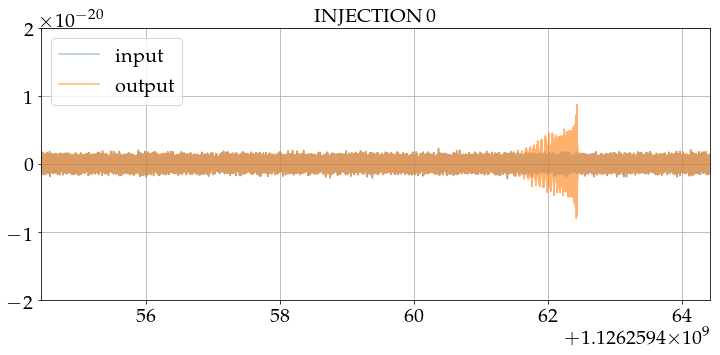

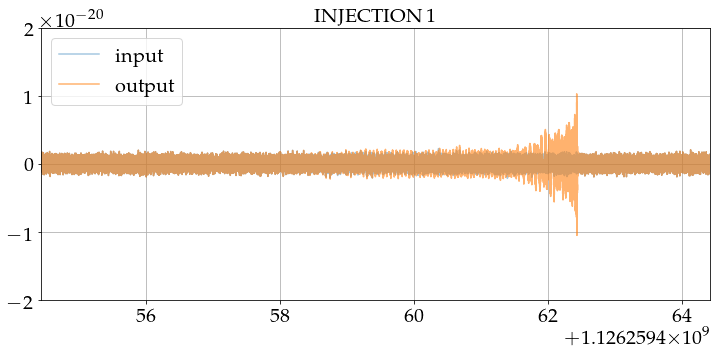

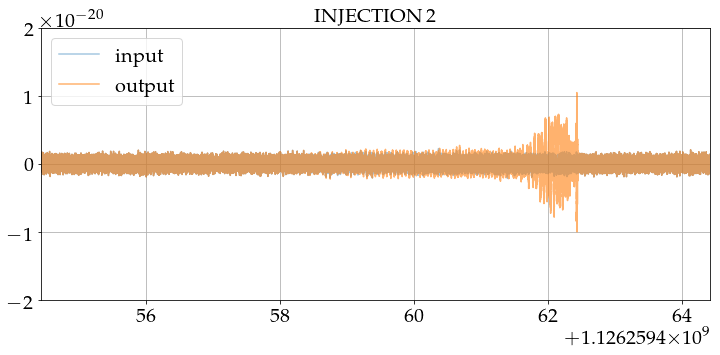

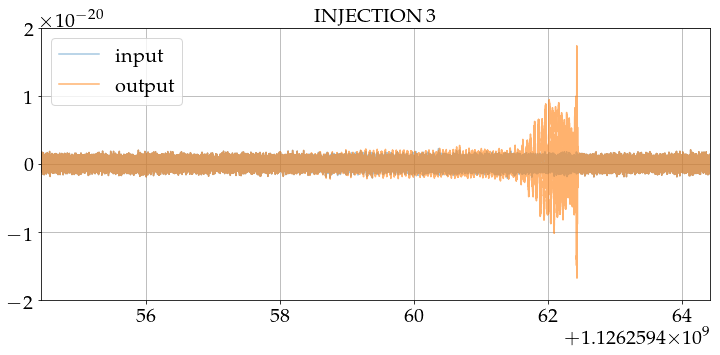

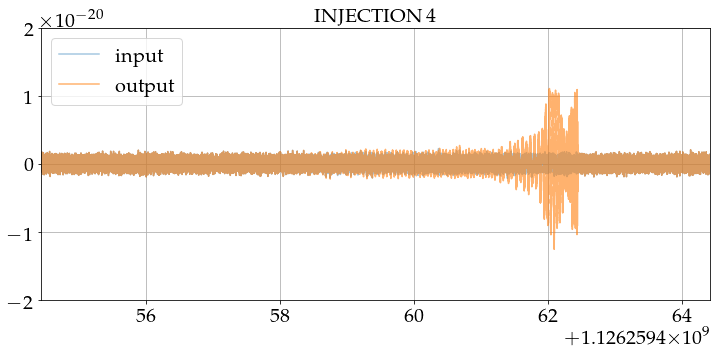

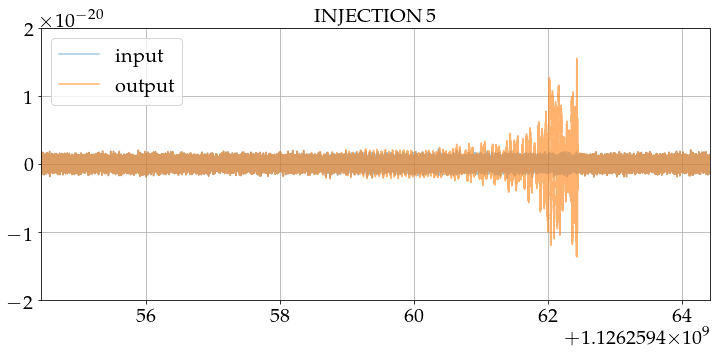

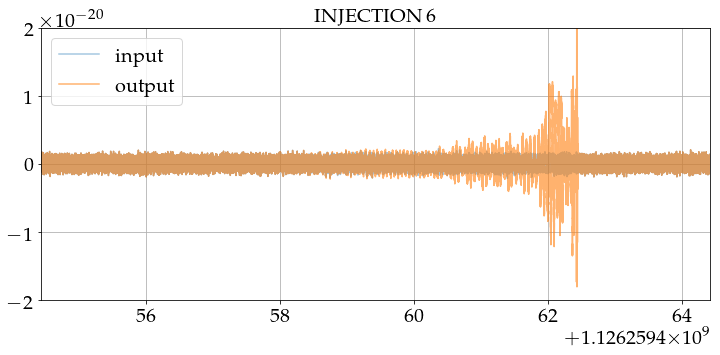

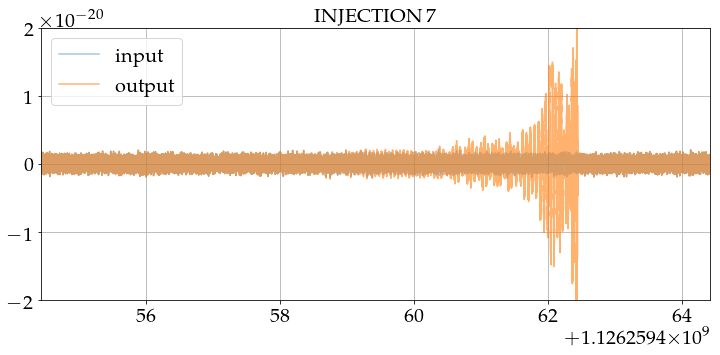

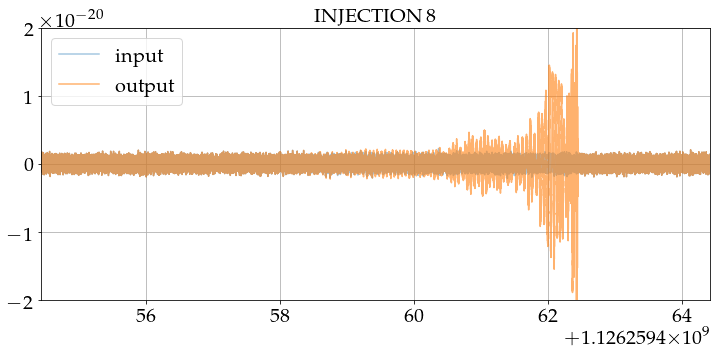

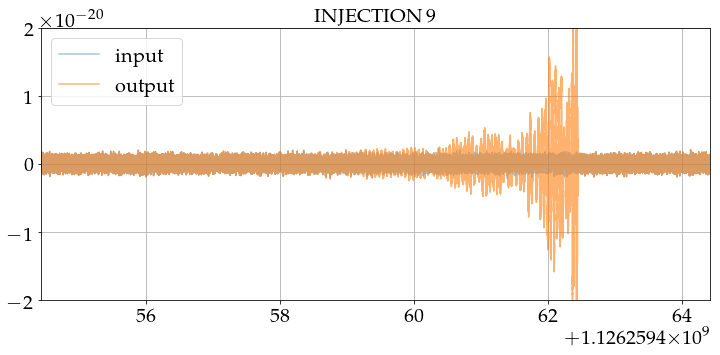

In [31]:
inj_s = {}
for ii in range(10):
    print("Making figure for injection {}".format(ii))
    inj_s[ii] = np.loadtxt('output_strain_after_inj{}.txt'.format(ii))
    
    figure(figsize = (12, 5))
    plot(in_s[:,0], in_s[:,1], alpha = 0.4, label = 'input')
    plot(inj_s[ii][:,0], inj_s[ii][:,1], alpha = 0.6, label = 'output')
    
    xlim(inj_tc - 8, inj_tc + 2)
    ylim( -2e-20, 2e-20 )
    legend(loc = 'best')
    grid()
    title('INJECTION {}'.format(ii))

>> **DECISION**: We will generate a new `injection.hdf` for each individual run,
even if the intrinsic parameters of the injection are common amongst many.
>>> **pros**: Each `pycbc_inference` run remains self-contained and independent.<br>
>>> **cons**: Redundant calls to `pycbc_create_injections`, but this is a one-time cost.

> **`CondorJobHelper / SLURMJobHelper`**:
> - submit individual job
> - submit indivisual dag
> - restart individual job
> - restart individual dag
> - check status of individual job
> - check status of individual dag

In [ ]:
class CondorJobHelper():
    def __init__():
        return

class SLURMJobHelper():
    def __init__():
        return

> **`ConfigWriter`**:
> - takes in an `opts` object that contains info on sections and options
> - writes them to desired output file

In [76]:
class ConfigWriter():
    def __init__(self, opts, run_dir):
        self.opts = opts
        self.run_dir = run_dir
    def write(self):
        return

> **`InferenceConfigs`**:
> - stores all `config.ini` files
> - returns on demand. Compatible with ConfigWriter

In [77]:
# InferenceConfigs
class InferenceConfigs():
    def __init__(self, opts, run_dir, configs = {}):
        '''
 - stores all config.ini files
 - returns on demand. Compatible with ConfigWriter
        '''
        self.opts = opts
        self.run_dir = run_dir
        # Make this >>
        assert(isinstance(configs, dict))
        self.configs = configs
        self.configs['data'] = """\
[data]
instruments = H1 L1
trigger-time = 1126259462.42
analysis-start-time = -6
analysis-end-time = 2
; strain settings
sample-rate = 2048
fake-strain = H1:aLIGOaLIGODesignSensitivityT1800044 L1:aLIGOaLIGODesignSensitivityT1800044
fake-strain-seed = H1:44 L1:45
; psd settings
psd-estimation = median-mean
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
psd-start-time = -256
psd-end-time = 256
; even though we're making fake strain, the strain
; module requires a channel to be provided, so we'll
; just make one up
channel-name = H1:STRAIN L1:STRAIN
; Providing an injection file will cause a simulated
; signal to be added to the data
injection-file = injection.hdf
; We'll use a high-pass filter so as not to get numerical errors from the large
; amplitude low frequency noise. Here we use 15 Hz, which is safely below the
; low frequency cutoff of our likelihood integral (20 Hz)
strain-high-pass = 15
; The pad-data argument is for the high-pass filter: 8s are added to the
; beginning/end of the analysis/psd times when the data is loaded. After the
; high pass filter is applied, the additional time is discarded. This pad is
; *in addition to* the time added to the analysis start/end time for the PSD
; inverse length. Since it is discarded before the data is transformed for the
; likelihood integral, it has little affect on the run time.
pad-data = 8
"""
        self.configs['emcee_pt-gw150914_like'] = """\
[sampler]
name = emcee_pt
nwalkers = 200
ntemps = 20
effective-nsamples = 1000
checkpoint-interval = 2000
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = nacl & max_posterior

;
;   Sampling transforms
;
[sampling_params]
; parameters on the left will be sampled in
; parametes on the right
mass1, mass2 : mchirp, q

[sampling_transforms-mchirp+q]
; inputs mass1, mass2
; outputs mchirp, q
name = mass1_mass2_to_mchirp_q
"""
        self.configs['gw150914_like'] = """\
[model]
name = gaussian_noise
low-frequency-cutoff = 20.0

[variable_params]
; waveform parameters that will vary in MCMC
delta_tc =
mass1 =
mass2 =
spin1_a =
spin1_azimuthal =
spin1_polar =
spin2_a =
spin2_azimuthal =
spin2_polar =
distance =
coa_phase =
inclination =
polarization =
ra =
dec =

[static_params]
; waveform parameters that will not change in MCMC
approximant = ENIGMA
f_lower = 20
f_ref = 20
; we'll set the tc by using the trigger time in the data
; section of the config file + delta_tc
trigger_time = ${data|trigger-time}

[prior-delta_tc]
; coalescence time prior
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
; we need to provide tc to the waveform generator
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc

[prior-mass1]
name = uniform
min-mass1 = 10.
max-mass1 = 80.

[prior-mass2]
name = uniform
min-mass2 = 10.
max-mass2 = 80.

[prior-spin1_a]
name = uniform
min-spin1_a = 0.0
max-spin1_a = 0.99

[prior-spin1_polar+spin1_azimuthal]
name = uniform_solidangle
polar-angle = spin1_polar
azimuthal-angle = spin1_azimuthal

[prior-spin2_a]
name = uniform
min-spin2_a = 0.0
max-spin2_a = 0.99

[prior-spin2_polar+spin2_azimuthal]
name = uniform_solidangle
polar-angle = spin2_polar
azimuthal-angle = spin2_azimuthal

[prior-distance]
; following gives a uniform volume prior
name = uniform_radius
min-distance = 10
max-distance = 1000

[prior-coa_phase]
; coalescence phase prior
name = uniform_angle

[prior-inclination]
; inclination prior
name = sin_angle

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-polarization]
; polarization prior
name = uniform_angle
"""
        self.config_names = self.configs.keys()
        
        self.config_writers = {}
        for config_name in self.config_names:
            self.config_writers[config_name] = ConfigWriter(opts, run_dir)
    def available_configs(self):
        return self.config_names
    def get(self, config_name):
        return self.configs[config_name]
    def set(self, config_name, config):
        self.configs[config_name] = configs

> **`InjectionInferenceAnalysis`**:
> - setup individual analysis dir
> - setup all analysis dirs
> - start / stop / restart individual analysis
> - check status of individual analysis

In [75]:
# InferenceAnalysis etc
class InferenceAnalysis():
    def __init__(self, opts, run_dir):
        self.opts = opts
        self.run_dir = run_dir
    def setup_run(self):
        return
    def submit_run(self):
        return
    def restart_run(self):
        return

class InjectionInference():
    def __init__(self, opts, run_dir):
        self.opts = opts
        self.run_dir = run_dir
    def setup_run(self):
        return
    def submit_run(self):
        return
    def restart_run(self):
        return

class InjectionInferenceAnalysis():
    def __init__(self, opts, run_dir):
        self.opts = opts
        self.run_dir = run_dir
    def setup_run(self):
        return
    def submit_run(self):
        return
    def restart_run(self):
        return

In [65]:
with open("data.ini", "w") as fout:
    fout.write("""\
[data]
instruments = H1 L1
trigger-time = 1126259462.42
analysis-start-time = -6
analysis-end-time = 2
; strain settings
sample-rate = 2048
fake-strain = H1:aLIGOaLIGODesignSensitivityT1800044 L1:aLIGOaLIGODesignSensitivityT1800044
fake-strain-seed = H1:44 L1:45
; psd settings
psd-estimation = median-mean
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
psd-start-time = -256
psd-end-time = 256
; even though we're making fake strain, the strain
; module requires a channel to be provided, so we'll
; just make one up
channel-name = H1:STRAIN L1:STRAIN
; Providing an injection file will cause a simulated
; signal to be added to the data
injection-file = injection.hdf
; We'll use a high-pass filter so as not to get numerical errors from the large
; amplitude low frequency noise. Here we use 15 Hz, which is safely below the
; low frequency cutoff of our likelihood integral (20 Hz)
strain-high-pass = 15
; The pad-data argument is for the high-pass filter: 8s are added to the
; beginning/end of the analysis/psd times when the data is loaded. After the
; high pass filter is applied, the additional time is discarded. This pad is
; *in addition to* the time added to the analysis start/end time for the PSD
; inverse length. Since it is discarded before the data is transformed for the
; likelihood integral, it has little affect on the run time.
pad-data = 8
""")

In [66]:
!cat data.ini

[data]
instruments = H1 L1
trigger-time = 1126259462.42
analysis-start-time = -6
analysis-end-time = 2
; strain settings
sample-rate = 2048
fake-strain = H1:aLIGOaLIGODesignSensitivityT1800044 L1:aLIGOaLIGODesignSensitivityT1800044
fake-strain-seed = H1:44 L1:45
; psd settings
psd-estimation = median-mean
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
psd-start-time = -256
psd-end-time = 256
; even though we're making fake strain, the strain
; module requires a channel to be provided, so we'll
; just make one up
channel-name = H1:STRAIN L1:STRAIN
; Providing an injection file will cause a simulated
; signal to be added to the data
injection-file = injection.hdf
; We'll use a high-pass filter so as not to get numerical errors from the large
; amplitude low frequency noise. Here we use 15 Hz, which is safely below the
; low frequency cutoff of our likelihood integral (20 Hz)
strain-high-pass = 15
; The pad-data argument is for the high-pass filter: 8s are added to t

In [67]:
with open("emcee_pt-gw150914_like.ini", "w") as fout:
    fout.write("""\
[sampler]
name = emcee_pt
nwalkers = 200
ntemps = 20
effective-nsamples = 1000
checkpoint-interval = 2000
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = nacl & max_posterior

;
;   Sampling transforms
;
[sampling_params]
; parameters on the left will be sampled in
; parametes on the right
mass1, mass2 : mchirp, q

[sampling_transforms-mchirp+q]
; inputs mass1, mass2
; outputs mchirp, q
name = mass1_mass2_to_mchirp_q
""")

In [68]:
!cat emcee_pt-gw150914_like.ini

[sampler]
name = emcee_pt
nwalkers = 200
ntemps = 20
effective-nsamples = 1000
checkpoint-interval = 2000
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = nacl & max_posterior

;
;   Sampling transforms
;
[sampling_params]
; parameters on the left will be sampled in
; parametes on the right
mass1, mass2 : mchirp, q

[sampling_transforms-mchirp+q]
; inputs mass1, mass2
; outputs mchirp, q
name = mass1_mass2_to_mchirp_q


In [74]:
with open("gw150914_like.ini", "w") as fout:
    fout.write("""\
[model]
name = gaussian_noise
low-frequency-cutoff = 20.0

[variable_params]
; waveform parameters that will vary in MCMC
delta_tc =
mass1 =
mass2 =
spin1_a =
spin1_azimuthal =
spin1_polar =
spin2_a =
spin2_azimuthal =
spin2_polar =
distance =
coa_phase =
inclination =
polarization =
ra =
dec =

[static_params]
; waveform parameters that will not change in MCMC
approximant = ENIGMA
f_lower = 20
f_ref = 20
; we'll set the tc by using the trigger time in the data
; section of the config file + delta_tc
trigger_time = ${data|trigger-time}

[prior-delta_tc]
; coalescence time prior
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
; we need to provide tc to the waveform generator
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc

[prior-mass1]
name = uniform
min-mass1 = 10.
max-mass1 = 80.

[prior-mass2]
name = uniform
min-mass2 = 10.
max-mass2 = 80.

[prior-spin1_a]
name = uniform
min-spin1_a = 0.0
max-spin1_a = 0.99

[prior-spin1_polar+spin1_azimuthal]
name = uniform_solidangle
polar-angle = spin1_polar
azimuthal-angle = spin1_azimuthal

[prior-spin2_a]
name = uniform
min-spin2_a = 0.0
max-spin2_a = 0.99

[prior-spin2_polar+spin2_azimuthal]
name = uniform_solidangle
polar-angle = spin2_polar
azimuthal-angle = spin2_azimuthal

[prior-distance]
; following gives a uniform volume prior
name = uniform_radius
min-distance = 10
max-distance = 1000

[prior-coa_phase]
; coalescence phase prior
name = uniform_angle

[prior-inclination]
; inclination prior
name = sin_angle

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-polarization]
; polarization prior
name = uniform_angle
""")

In [70]:
!cat gw150914_like.ini

[model]
name = gaussian_noise
low-frequency-cutoff = 20.0

[variable_params]
; waveform parameters that will vary in MCMC
delta_tc =
mass1 =
mass2 =
spin1_a =
spin1_azimuthal =
spin1_polar =
spin2_a =
spin2_azimuthal =
spin2_polar =
distance =
coa_phase =
inclination =
polarization =
ra =
dec =

[static_params]
; waveform parameters that will not change in MCMC
approximant = IMRPhenomPv2
f_lower = 20
f_ref = 20
; we'll set the tc by using the trigger time in the data
; section of the config file + delta_tc
trigger_time = ${data|trigger-time}

[prior-delta_tc]
; coalescence time prior
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
; we need to provide tc to the waveform generator
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc

[prior-mass1]
name = uniform
min-mass1 = 10.
max-mass1 = 80.

[prior-mass2]
name = uniform
min-mass2 = 10.
max-mass2 = 80.

[prior-spin1_a]
name = uniform
min-spin1_a = 0.0
max-spin1_a = 0.99

[prior-spin1_pol

In [72]:
with open("run.sh", "w") as fout:
    fout.write("""#!/bin/sh

# sampler parameters
PRIOR_CONFIG=gw150914_like.ini
DATA_CONFIG=data.ini
SAMPLER_CONFIG=emcee_pt-gw150914_like.ini
OUTPUT_PATH=inference.hdf

# the following sets the number of cores to use; adjust as needed to
# your computer's capabilities
NPROCS=10

# run sampler
# Running with OMP_NUM_THREADS=1 stops lalsimulation
# from spawning multiple jobs that would otherwise be used
# by pycbc_inference and cause a reduced runtime.
OMP_NUM_THREADS=1 \
pycbc_inference --verbose \
    --seed 12 \
    --config-file ${PRIOR_CONFIG} ${DATA_CONFIG} ${SAMPLER_CONFIG} \
    --output-file ${OUTPUT_PATH} \
    --nprocesses ${NPROCS} \
    --force
""")

In [73]:
!cat run.sh

#!/bin/sh

# sampler parameters
PRIOR_CONFIG=gw150914_like.ini
DATA_CONFIG=data.ini
SAMPLER_CONFIG=emcee_pt-gw150914_like.ini
OUTPUT_PATH=inference.hdf

# the following sets the number of cores to use; adjust as needed to
# your computer's capabilities
NPROCS=10

# run sampler
# Running with OMP_NUM_THREADS=1 stops lalsimulation
# from spawning multiple jobs that would otherwise be used
# by pycbc_inference and cause a reduced runtime.
OMP_NUM_THREADS=1 pycbc_inference --verbose     --seed 12     --config-file ${PRIOR_CONFIG} ${DATA_CONFIG} ${SAMPLER_CONFIG}     --output-file ${OUTPUT_PATH}     --nprocesses ${NPROCS}     --force
